In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier,\
AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

df = pd.read_csv("titanic.csv")


In [3]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    print('\n')
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)


In [114]:
classifiers = pd.DataFrame()


bagging = ['Bagging Classifier', 'Random Forest', 'Extra Trees Classifier']
boosting = ['AdaBoost', 'Gradient Boosting (GBM)', 'XGBoost']

classifiers['Bagging Algorithms'] = bagging

classifiers['Boosting Algorithms'] = boosting

classifiers

,Bagging Algorithms,Boosting Algorithms
0,Bagging Classifier,AdaBoost
1,Random Forest,Gradient Boosting (GBM)
2,Extra Trees Classifier,XGBoost


In [4]:
df = df[['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Sex', 'Parch', 'Fare', 'Embarked']]
df = df[df.Parch != 6]
df.Embarked = df.Embarked.fillna(value='S')
df.Age = df.Age.fillna(value=df.Age.mean())
print(df.isna().sum())
df.head()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Sex            0
Parch          0
Fare           0
Embarked       0
dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Sex,Parch,Fare,Embarked
0,1,0,3,22.0,1,male,0,7.2500,S
1,2,1,1,38.0,1,female,0,71.2833,C
2,3,1,3,26.0,0,female,0,7.9250,S
3,4,1,1,35.0,1,female,0,53.1000,S
4,5,0,3,35.0,0,male,0,8.0500,S


In [5]:
X = df.drop(['Survived'], axis=1)
y = df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
numerical = ['Age', 'Fare']
categorical = ["Pclass", "Sex",
                       "SibSp", "Parch", "Embarked"]

In [7]:
ss = Pipeline(steps=[('ss', StandardScaler())])
ohe = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])

preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, numerical),
                        ('cat', ohe, categorical)
                    ])
dtree_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', DecisionTreeClassifier())
])

In [8]:
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('classifier', DecisionTreeClassifier())])

Train Accuracy: 0.9835082458770614
Test Accuracy: 0.7802690582959642


Recall:  0.6896551724137931
Accuracy:  0.7802690582959642
Precision:  0.7317073170731707
F1:  0.7100591715976332




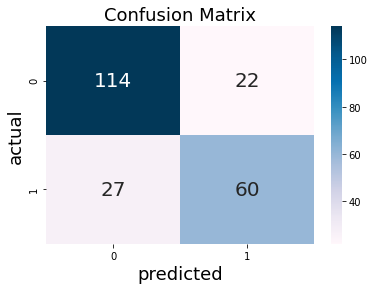

In [9]:
train_acc = accuracy_score(y_train, dtree_pipe.predict(X_train))
test_acc = accuracy_score(y_test, dtree_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, dtree_pipe.predict(X_test))

Train Accuracy: 0.7886056971514243
Test Accuracy: 0.7892376681614349


Recall:  0.6781609195402298
Accuracy:  0.7892376681614349
Precision:  0.7564102564102564
F1:  0.7151515151515151




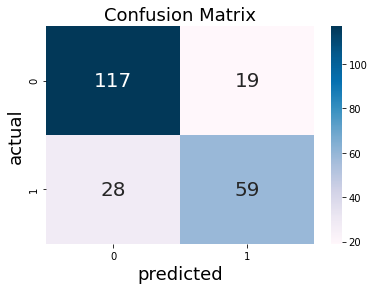

In [10]:
bagging_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', BaggingClassifier(n_estimators=200, max_samples=20))
])

bagging_pipe.fit(X_train, y_train)

train_acc = accuracy_score(y_train, bagging_pipe.predict(X_train))
test_acc = accuracy_score(y_test, bagging_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, bagging_pipe.predict(X_test))

Train Accuracy: 0.8125937031484258
Test Accuracy: 0.8116591928251121


Recall:  0.6436781609195402
Accuracy:  0.8116591928251121
Precision:  0.835820895522388
F1:  0.7272727272727273




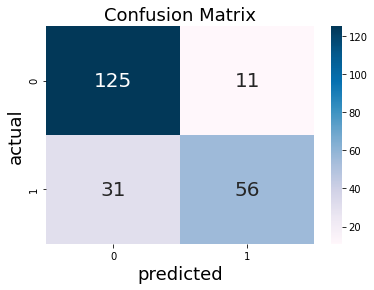

In [27]:
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', RandomForestClassifier(n_estimators=500, max_samples=20))
])

rf_pipe.fit(X_train, y_train)

train_acc = accuracy_score(y_train, rf_pipe.predict(X_train))
test_acc = accuracy_score(y_test, rf_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, rf_pipe.predict(X_test))

Train Accuracy: 0.8215892053973014
Test Accuracy: 0.8161434977578476


Recall:  0.6436781609195402
Accuracy:  0.8161434977578476
Precision:  0.8484848484848485
F1:  0.7320261437908496




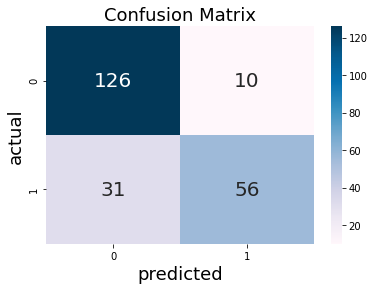

In [42]:
et_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', ExtraTreesClassifier(bootstrap=True, n_estimators=400, max_samples=30))
])

et_pipe.fit(X_train, y_train)

train_acc = accuracy_score(y_train, et_pipe.predict(X_train))
test_acc = accuracy_score(y_test, et_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, et_pipe.predict(X_test))

Train Accuracy: 0.8365817091454273
Test Accuracy: 0.8116591928251121


Recall:  0.7471264367816092
Accuracy:  0.8116591928251121
Precision:  0.7647058823529411
F1:  0.755813953488372




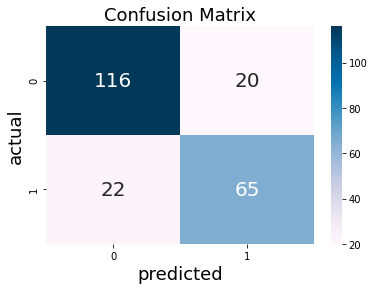

In [43]:
ada_boost_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', AdaBoostClassifier())
])

ada_boost_pipe.fit(X_train, y_train)

train_acc = accuracy_score(y_train, ada_boost_pipe.predict(X_train))
test_acc = accuracy_score(y_test, ada_boost_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, ada_boost_pipe.predict(X_test))

Train Accuracy: 0.9085457271364318
Test Accuracy: 0.820627802690583


Recall:  0.7011494252873564
Accuracy:  0.820627802690583
Precision:  0.8133333333333334
F1:  0.7530864197530864




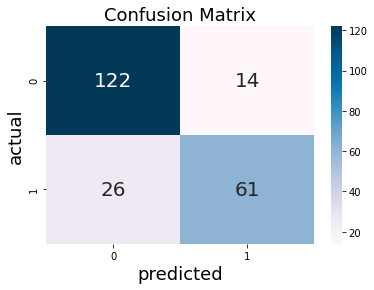

In [112]:
gbm_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', GradientBoostingClassifier(learning_rate=0.12))
])

gbm_pipe.fit(X_train, y_train)

train_acc = accuracy_score(y_train, gbm_pipe.predict(X_train))
test_acc = accuracy_score(y_test, gbm_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, gbm_pipe.predict(X_test))

Train Accuracy: 0.9010494752623688
Test Accuracy: 0.8385650224215246


Recall:  0.7126436781609196
Accuracy:  0.8385650224215246
Precision:  0.8493150684931506
F1:  0.7749999999999999




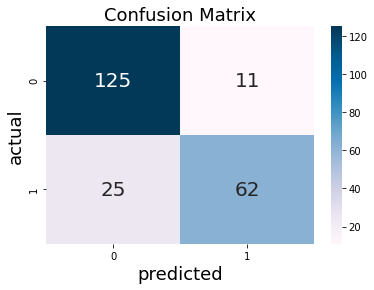

In [99]:
xg_boost_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', xgb.XGBClassifier(learning_rate=0.15))
])

xg_boost_pipe.fit(X_train, y_train)

train_acc = accuracy_score(y_train, xg_boost_pipe.predict(X_train))
test_acc = accuracy_score(y_test, xg_boost_pipe.predict(X_test))

print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))
print('\n')
evaluation(y_test, xg_boost_pipe.predict(X_test))